## Data loading and tokenization

In [1]:
# For any notebook
!git clone https://github.com/nMaax/danteGPT
!pip install -r danteGPT/requirements.txt

import os
os.chdir('danteGPT')

Cloning into 'danteGPT'...
remote: Enumerating objects: 136, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (107/107), done.
remote: Total 136 (delta 59), reused 89 (delta 27), pack-reused 0 (from 0)
Receiving objects: 100% (136/136), 684.19 KiB | 14.56 MiB/s, done.
Resolving deltas: 100% (59/59), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 839.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━

In [2]:
import yaml

# Load the configuration from the YAML file
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

tokenizer_training_size = config['model']['tokenizer_training_size']
train_test_ratio = config['model']['train_test_ratio']
vocab_size = config['model']['vocab_size']
block_size = config['model']['block_size']
batch_size = config['model']['batch_size']
d_model = config['model']['d_model']
num_heads = config['model']['num_heads']
num_transformer_blocks = config['model']['num_transformer_blocks']
ff_expansion_factor = config['model']['ff_expansion_factor']
dropout_rate = config['model']['dropout_rate']
device = config['model']['device']

In [3]:
# Read the file
with open('divina_commedia.txt', 'r', encoding='utf-8') as f:
  text = f.read()

In [4]:
print(text[:512])

INFERNO CANTO 1
Nel mezzo del cammin di nostra vita
mi ritrovai per una selva oscura
ché la diritta via era smarrita.
Ahi quanto a dir qual era è cosa dura
esta selva selvaggia e aspra e forte
che nel pensier rinova la paura!
Tant' è amara che poco è più morte;
ma per trattar del ben ch'i' vi trovai,
dirò de l'altre cose ch'i' v'ho scorte.
Io non so ben ridir com' i' v'intrai,
tant' era pien di sonno a quel punto
che la verace via abbandonai.
Ma poi ch'i' fui al piè d'un colle giunto,
là dove terminava quel


In [5]:
from tokenizer import RegexTokenizer

tokenizer_training_size = int(len(text) * tokenizer_training_size)

Dantokenizer = RegexTokenizer()
Dantokenizer.train(text[:tokenizer_training_size], vocab_size=vocab_size)

In [6]:
encode = Dantokenizer.encode
decode = Dantokenizer.decode

In [7]:
print(decode(encode('Nel mezzo del cammin di nostra vita, mi ritrovai in una selva oscura.')))

Nel mezzo del cammin di nostra vita, mi ritrovai in una selva oscura.


In [8]:
import torch

data = torch.tensor(encode(text), dtype=torch.long)
n = int(train_test_ratio*len(data))
train_data = data[:n]
test_data = data[n:]

In [9]:
# Check for GPU availability and move model and data
if device == "cpu":
    device = torch.device("cpu")
    print("Training on CPU.")
elif device == "cuda" and torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Training on:", device)
else:
    device = torch.device("cpu")
    print("GPU not available. Training on CPU.")

GPU is available. Training on: cuda


## Baseline, Transformer-free model

In [10]:
from baseline import DanteBaseline
naiveDante = DanteBaseline(vocab_size=vocab_size, embedding_dim=d_model, context_window=block_size, ff_expansion_factor=ff_expansion_factor).to(device)

In [11]:
def novel_generate(model, size=500, device=None):
  if device is None:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use CUDA if available
  return decode(model.generate(context=torch.zeros((1, 1), dtype=torch.long, device=device), max_new_tokens=size)[0].tolist())

In [12]:
with torch.no_grad():
  print(novel_generate(model=naiveDante, device=device))

  de pareaernotanto color�spuoseole�van <<enaal� sta era� priù mezzo più rendiv sii�@ spiineche�osa? elru ènon carh mioSsaé� guar ven dal dinanzi sue1'altra so ognechia mioando
 ru�� ben me�yFcosì�vaK['an parqio� to riguar tuaveaoso questa'hAllorpa� pare sta� lossertà� giàV tehedre grigi guichiaINFTgueccchéosta suaanza driin!>>.
�� vendar convien:
� sartt colmpre mai assai sìF��EdglieG Dioostroppgl du SQuono�ttaunqueannoosdelgi cerchéosta sùcometmegatu disseiocea Ado vinpera al suavassi;
sta	pertra parole"��ombspuenovamhe��M comincchi guigua sta gentiggi�li sc gragri orpera4'ATu cheLaghizzineare�Cà'hCando monssa�esig7ore� F%cqu ciascun cre fi vita'acqua� siaestestiaro��cqu portaurasso carmmi�Z senti,uol questa frecomeonteedeetaià�>� dis M�Qu b'urivra loro daestiina suo sia ha�La'ani sìgliconzio loro adzio a fummo dove già com povan nostra petto mis$os�cun comin� sanza'io tentrigue� preiasc esserman to�'altrax� sù pers buiascriffi giuspu R� dovmarse�/ G M alcunos� ar� mondo tut

In [13]:
from utils import train_model, plot_loss_functions

optimizer = torch.optim.AdamW(naiveDante.parameters(), lr=1e-3)
epochs = 5 * 1000

train_loss_values, test_loss_values = train_model(model=naiveDante, train_data=train_data, test_data=test_data, optimizer=optimizer, epochs=epochs, block_size=block_size, batch_size=batch_size, device=device)

Epoch 0: Train Loss = 6.9288, Test Loss = 6.8816
Epoch 1000: Train Loss = 4.2015, Test Loss = 4.4356
Epoch 2000: Train Loss = 4.1243, Test Loss = 4.4134
Epoch 3000: Train Loss = 4.0136, Test Loss = 4.3699
Epoch 4000: Train Loss = 4.0534, Test Loss = 4.3364


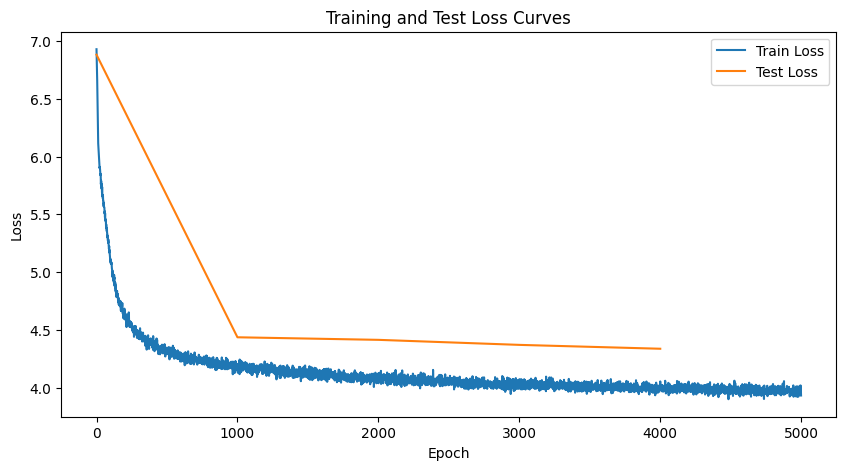

In [14]:
plot_loss_functions(train_loss_values, test_loss_values, epochs=epochs)

In [15]:
with torch.no_grad():
  print(novel_generate(model=naiveDante, size=500, device=device))

 re
forza:
ché piantil'arserò sì che sare intui che parlar la tua: <<Or si fro;
perchiancemosto lor sinitese>>.
<<O CANTO onte Vincome le notte: <<ra
 dim'inno escose
che non eran m'ha mascavi nel sembian lieta, <<Per ch'ammi unta;
persiglio,
etto uman.
S'io ch' untati,
in dove tuoi, natura mai non l'ammi suse
tra 'lan sì ciglia,
quando di grommanantranno!".
<<Lo mio, stani,
per, stava male torrembribilicea; e sanza prima
da in mano sa si radi asso;
or che la brizzonte
etro si rico ciò noser li atta cost' volse non discerno perché sacine,
non la proverò con lui segnor ti porte,
la scalto,
pestui
dio e in un fummo riper la manocca
che 'nte,
quandongià de la mente
per cigli
che gigine da la mani avan disge;
evolse ma fiamoreanterna, se ben farno poi che l'unghi.
Di vedere onorno,
non soesare in un sermostra per la nove un di fore fatta.
Questa,
non fuggioro è quella venne' è vinciolta fa in giù coper le ma guarda,
quandele odovedei,
che già dato,
so, e disvarmi parea di prtùbisso poorno,

## Transformer based (self attention) implementation

In [16]:
from dante import DanteTransformer

In [17]:
Dante = DanteTransformer(vocab_size=vocab_size, block_size=block_size, d_model=d_model, num_heads=num_heads, num_transformer_blocks=num_transformer_blocks, ff_expansion_factor=ff_expansion_factor, dropout_rate=dropout_rate).to(device)

In [18]:
with torch.no_grad():
  print(novel_generate(model=Dante, device=device))

keste� Dێcci pu�ai gran�R sue�INFER mia.cchio valle'avea5raimpresci>>albbe�nauol sanza dovvi8 una�� sue ca terraanta color ' una'hffi�tu so'erestiVte disp'o� ma'aveagli renero renalma valle tuaw� cor pazz grannoere angnedeelleerra monmb no dol'un{cor sentivrap) dolceINFERNOQperachébbiaone dovAose����tarcom� cre spven ven3spu son quanto�cchioià dol� tivertsa bapartu�tenutoINF fondo sì coniù�renquientiaro� manéero né mor�eiesecendoirc granpoi ch7� giù color men�ea� pettoQuandofuer genti* dolor voei cortresc>>,
� re qua d�é�estaondotu b�ciò i <<hiccia cielce'altraquesser�era'occhiooscia� falIn�ea quellabberaiìchi'u� sùericia veder <<�! car'occhiossaizia��glie noi� arga� so giù questi nonva��estrosci griosa in questoroiò mezzo


In [19]:
from utils import train_model, plot_loss_functions

optimizer = torch.optim.AdamW(Dante.parameters(), lr=1e-3)
epochs = 10 * 1000

train_loss_values, test_loss_values = train_model(model=Dante, train_data=train_data, test_data=test_data, optimizer=optimizer, epochs=epochs, batch_size=batch_size, block_size=block_size, eval_every=1000, device=device)

Epoch 0: Train Loss = 7.0749, Test Loss = 6.8940
Epoch 1000: Train Loss = 3.3167, Test Loss = 4.2209
Epoch 2000: Train Loss = 2.1828, Test Loss = 5.0464
Epoch 3000: Train Loss = 1.6388, Test Loss = 6.0478


KeyboardInterrupt: 

In [ ]:
plot_loss_functions(train_loss_values, test_loss_values, epochs=epochs)

In [20]:
with torch.no_grad():
  print(novel_generate(model=Dante, size=500, device=device))

ote,
tal v'ha m'offetto b piegento spronto e discoverto.
Per veder si con e con ucce patretti
gogna più e più alto e più cin turuno;
ché poi credi che tutto fossi,
non sì mi lo rech' tra 'ncarca
del triel demonio suo fatta ma figlio.
Minò Virgilio che 'lio, e quel pinto
lo lume convento Semi Pier di me,
che, quando disse: 'Marne a Chatiroesto Lucano,
a Sa diabelianabena le fi'.
Per ch'i' videvo e Abidi, e Plagia e altri go
per li altri china edlico, anche, non lo 'l Reno
mio non potel loco, a giova si fu offi?
Già veggima, ché così vegneria
soproccia il passa del Santo.
Quive si fu a li al cuna parte Pe
de l'altro


In [ ]:
#torch.save(Dante.state_dict(), 'DanteGPT_weights.pth')